# Imports

In [44]:
!pip install seaborn
!pip install ucimlrepo
!pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics

# Loading dataset

Link to Wine dataset: https://archive.ics.uci.edu/dataset/109/wine

In [76]:
from ucimlrepo import fetch_ucirepo 

abalone = fetch_ucirepo(id=1) 
  
X = abalone.data.features 


In [112]:
print(X)

[[-1.15434629 -0.57455813 -0.43214879 ... -0.60768536 -0.72621157
  -0.63821689]
 [-1.15434629 -1.44898585 -1.439929   ... -1.17090984 -1.20522124
  -1.21298732]
 [ 0.05379815  0.05003309  0.12213032 ... -0.4634999  -0.35668983
  -0.20713907]
 ...
 [-1.15434629  0.6329849   0.67640943 ...  0.74855917  0.97541324
   0.49695471]
 [ 0.05379815  0.84118198  0.77718745 ...  0.77334105  0.73362741
   0.41073914]
 [-1.15434629  1.54905203  1.48263359 ...  2.64099341  1.78744868
   1.84048058]]


## Categorical features

In [78]:
X.loc['Sex'] = X['Sex'].replace('M', 0)
X['Sex'] = X['Sex'].replace('F', 1)
X['Sex'] = X['Sex'].replace('I', 2)

/tmp/ipykernel_43285/1219785041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = X['Sex'].replace('M', 0)
/tmp/ipykernel_43285/1219785041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = X['Sex'].replace('F', 1)
/tmp/ipykernel_43285/1219785041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

## Features normalization

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)

# Clustering

## Kmeans

### Elbow Visualization

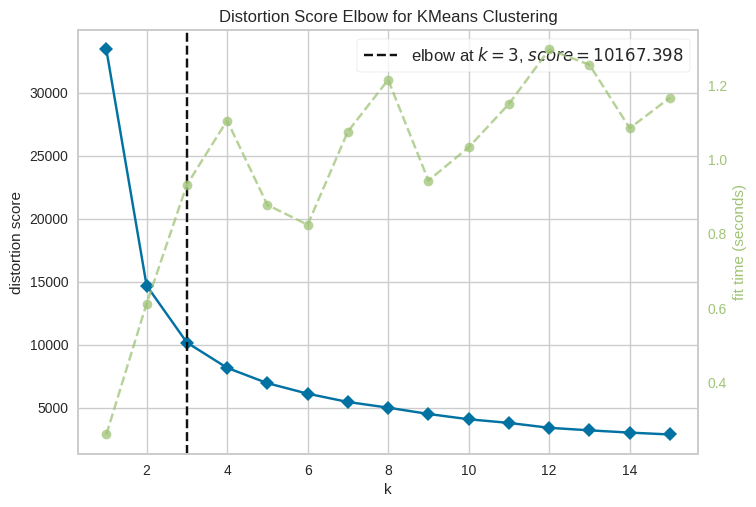

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [90]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1, 16))

visualizer.fit(X) 
visualizer.poof()

Apparently, the higher the k, the lowest the score, but choosing a value too high would likely lead to overfitting, so it would be best to settle at k=4.

### Calculating silhouette coefficient for different k's

In [93]:
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X)
    clusters = kmeans.fit_predict(X)

    silhouette = metrics.silhouette_score(X, clusters)

    print(f'Silhouette coefficient for K={k}: {silhouette:.2f}')

Silhouette coefficient for K=2: 0.46
Silhouette coefficient for K=3: 0.37
Silhouette coefficient for K=4: 0.33
Silhouette coefficient for K=5: 0.32
Silhouette coefficient for K=6: 0.32
Silhouette coefficient for K=7: 0.31
Silhouette coefficient for K=8: 0.32
Silhouette coefficient for K=9: 0.31
Silhouette coefficient for K=10: 0.31


As showed, when k > 4, the silhouette gain becomes too minimum to justify itself.

### Clusters visualization

In [94]:
k = 4

kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(X)
clusters = kmeans.fit_predict(X)

centroids = kmeans.cluster_centers_
labels = np.unique(clusters)

To visualize the clusters in a 2-D chart, we need first to decompose our features to only 2, which will unfortunately result in a loss of information

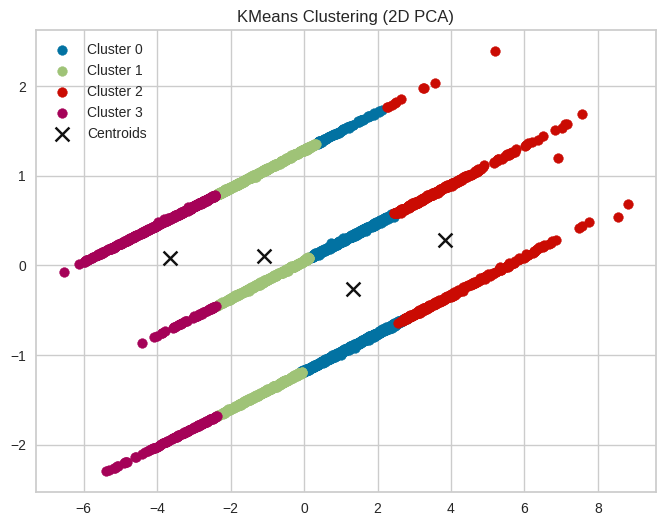

In [95]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Get centroids in 2D space
centroids = pca.transform(kmeans.cluster_centers_)

# Plot clusters
plt.figure(figsize=(8, 6))

for cluster_label in np.unique(clusters):
    plt.scatter(X_pca[clusters == cluster_label, 0],
                X_pca[clusters == cluster_label, 1],
                label=f'Cluster {cluster_label}')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='k', s=100, label='Centroids')

plt.title('KMeans Clustering (2D PCA)')
plt.legend()
plt.grid(True)
plt.show()

## DBSCAN

### Finding best parameters

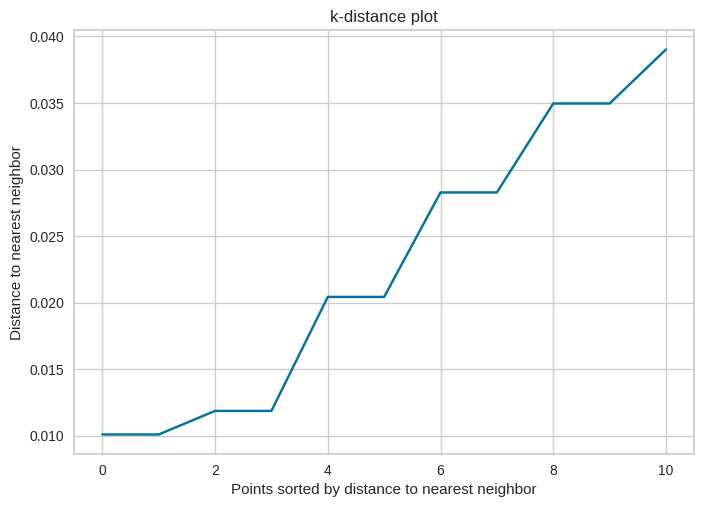

In [85]:
from sklearn.neighbors import NearestNeighbors

# Fit a nearest neighbors model
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nn.kneighbors(X)

# Sort the distances of each point by the k-th nearest neighbor
distances = np.sort(distances, axis=0)
distances = distances[0:11,1] # Take the distances to the k-th neighbor (the first neighbor is the point itself)

# Plot the k-distance plot
plt.plot(distances)
plt.xlabel('Points sorted by distance to nearest neighbor')
plt.ylabel('Distance to nearest neighbor')
plt.title('k-distance plot')
plt.show()

3 seems to be our best epsilon-value here, seeing its growth curve.

In [98]:
eps_value = 3

In [109]:
from sklearn.cluster import DBSCAN
eps_values = range(1, 11)
min_samples_values = range(1, 11)  # Try values from 1 to 10
silhouette_scores = []

for min_samples in min_samples_values:
    dbscan = DBSCAN(eps=4, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    
    print(f'Silhouette score for eps={eps}, min_samples={min_samples}: {metrics.silhouette_score(X, clusters):.2f}')

Silhouette score for eps=10, min_samples=1: 0.68
Silhouette score for eps=10, min_samples=2: 0.80
Silhouette score for eps=10, min_samples=3: 0.80
Silhouette score for eps=10, min_samples=4: 0.80
Silhouette score for eps=10, min_samples=5: 0.80
Silhouette score for eps=10, min_samples=6: 0.80
Silhouette score for eps=10, min_samples=7: 0.80
Silhouette score for eps=10, min_samples=8: 0.80
Silhouette score for eps=10, min_samples=9: 0.80
Silhouette score for eps=10, min_samples=10: 0.80


In [103]:
best_min_samples = 2

[0 0 0 ... 0 0 0]


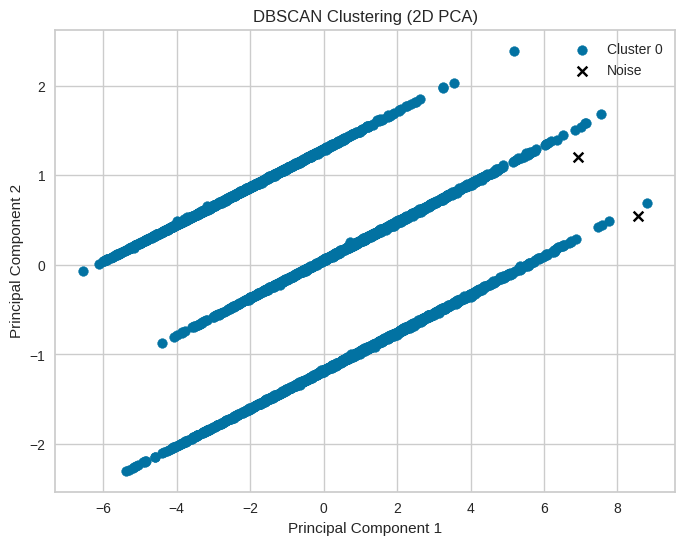

In [110]:
# Apply DBSCAN
dbscan = DBSCAN(eps=4, min_samples=10)
clusters = dbscan.fit_predict(X)

print(clusters)
# Get unique labels (clusters), ignoring noise points (-1)
unique_labels = np.unique(clusters[clusters != -1])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Get unique labels (clusters), ignoring noise points (-1)
unique_labels = np.unique(clusters[clusters != -1])

# Plot clusters
plt.figure(figsize=(8, 6))
for label in unique_labels:
    cluster = X_pca[clusters == label]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {label}')

# Plot noise points (cluster == -1)
noise_points = X_pca[clusters == -1]
plt.scatter(noise_points[:, 0], noise_points[:, 1], color='black', marker='x', label='Noise')

plt.title('DBSCAN Clustering (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()